<a href="https://colab.research.google.com/github/Bhanuprasad13/LungCancerDetection/blob/main/LungCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import warnings
phases = ['training', 'validation']
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
class ConvNet(nn.Module):
    def __init__(self, model, num_classes):
        super(ConvNet, self).__init__()
        self.base_model = nn.Sequential(*list(model.children())[:-1])
        self.linear1 = nn.Linear(in_features=2048, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=num_classes)
        self.relu = nn.LeakyReLU()
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients
    def get_activations(self, x):
        return self.base_model[:-1](x)
    def forward(self, x):
        x = self.base_model(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        lin = self.relu(x)
        x = self.linear2(lin)
        return lin, x
def train_model(model, criterion, optimizer, scheduler, data_loader, batch_size, num_epochs=30):

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0

    for epoch in range(num_epochs):

        for phase in phases:
            if phase == 'training':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_corrects = 0

            for ii, (images, labels) in enumerate(data_loader[phase]):

                images = images.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'training'):
                    _, outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                epoch_corrects += torch.sum(preds == labels.data)
                epoch_loss += loss.item() * images.size(0)

            epoch_accuracy = epoch_corrects/len(data_loader[phase])
            epoch_loss /= len(data_loader[phase])

            # store statistics
            if phase == 'training':
                train_loss.append(epoch_loss)
                epoch_accuracy = epoch_accuracy / float(batch_size)
                train_acc.append(epoch_accuracy)
                scheduler.step()
            if phase == 'validation':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_accuracy)

            print(f'Epoch: [{epoch+1}/{num_epochs}] Phase: {phase} | Loss: {epoch_loss:.6f} Accuracy: {epoch_accuracy:.6f}')

            # deep copy the best model weights
            if phase == 'validation' and epoch_accuracy >= best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'====> Best accuracy reached so far at Epoch {epoch+1} Accuracy = {best_accuracy:.6f}')

        print('-------------------------------------------------------------------------')

    # training complete
    print(f'Best Validation Accuracy: {best_accuracy:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss.copy(),
        'train_acc': train_acc.copy(),
        'val_loss': val_loss.copy(),
        'val_acc': val_acc.copy()
    }

    return model, history


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
data_directory = './'
epochs = 10
batch_size = 32
learning_rate = 0.0001
stepLR = 5
momentum = 0.9
print(f"data_directory: {data_directory}, epochs: {epochs}, batch_size: {batch_size}, learning_rate: {learning_rate}, stepLR: {stepLR}, momentum: {momentum}")
DIR_PATH = r"/content/drive/MyDrive/data_set3"
if DIR_PATH[-1]=='/':
    DIR_PATH = DIR_PATH[:-1]
TRAIN_DIR_PATH = os.path.join(DIR_PATH, 'train')
VAL_DIR_PATH = os.path.join(DIR_PATH, 'val')
print(TRAIN_DIR_PATH )
print(VAL_DIR_PATH )
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(mean)
print(std)
transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1),shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

}
train_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/data_set3/train", transform=transformations['train'])
val_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/data_set3/test", transform=transformations['val'])
test_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/val", transform=transformations['test'])


classes_to_idx = train_dataset.class_to_idx
print(classes_to_idx)
train_batch_size = batch_size
learning_rate = learning_rate
num_classes = len(classes_to_idx)
num_epochs = epochs
print(train_batch_size)
print(learning_rate)
print(num_classes )
print(num_epochs)
phases = ['training', 'validation']

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4),
    'testing':DataLoader(dataset=test_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4)
}
for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')

model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)
print(model)
model = ConvNet(model, num_classes)
model = model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=stepLR, gamma=0.1)
print(criterion)
print(optimizer)
print(exp_lr_scheduler)


data_directory: ./, epochs: 10, batch_size: 32, learning_rate: 0.0001, stepLR: 5, momentum: 0.9
/content/drive/MyDrive/data_set3/train
/content/drive/MyDrive/data_set3/val
[0.485 0.456 0.406]
[0.229 0.224 0.225]
{'LUNG_CANCER': 0, 'NORMAL': 1}
32
0.0001
2
10
Length of training loader = 43
Length of validation loader = 451


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
start = time.time()
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size, num_epochs)
duration = time.time() - start
print(f'Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [1/10] Phase: training | Loss: 9.440480 Accuracy: 0.849564
Epoch: [1/10] Phase: validation | Loss: 0.102132 Accuracy: 0.964523
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.964523
-------------------------------------------------------------------------
Epoch: [2/10] Phase: training | Loss: 3.892843 Accuracy: 0.944767
Epoch: [2/10] Phase: validation | Loss: 0.083058 Accuracy: 0.964523
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.964523
-------------------------------------------------------------------------
Epoch: [3/10] Phase: training | Loss: 2.879359 Accuracy: 0.945494
Epoch: [3/10] Phase: validation | Loss: 0.095999 Accuracy: 0.971175
====> Best accuracy reached so far at Epoch 3 Accuracy = 0.971175
-------------------------------------------------------------------------
Epoch: [4/10] Phase: training | Loss: 2.570388 Accuracy: 0.960029
Epoch: [4/10] Phase: validation | Loss: 0.223589 Accuracy: 0.913525
--------------------------------------------

In [ ]:
torch.save(model.state_dict(), 'lung_cancer50_.pth')

In [ ]:
torch.save(model.state_dict(), 'lung_cancer50_.pth')

In [ ]:
try:
    torch.save(model.state_dict(), 'lung_cancer50_.pth')
    print("Model saved successfully!")
except Exception as e:
    print("Error occurred while saving the model:", e)


Model saved successfully!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.038424, Validation Accuracy: 0.988914
Accuracy: 0.988914
Precision: 0.990066
Recall: 0.993355
F1-Score: 0.991708
Confusion Matrix:
[[147   3]
 [  2 299]]


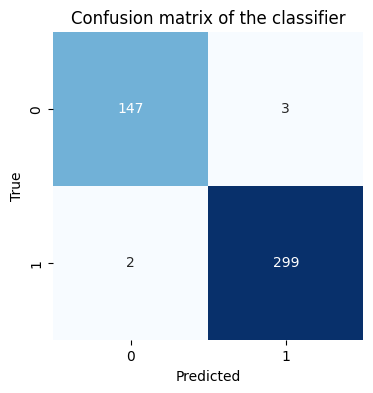

In [ ]:
import seaborn as sns
def evaluate_model(model, criterion, data_loader, phase):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader[phase]:
            images = images.to(device)
            labels = labels.to(device)

            _, outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader[phase].dataset)
    epoch_accuracy = running_corrects.double() / len(data_loader[phase].dataset)

    return epoch_loss, epoch_accuracy, all_labels, all_preds

val_loss, val_accuracy, all_labels, all_preds = evaluate_model(model, criterion, data_loader, 'validation')
print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-Score: {f1:.6f}')
print('Confusion Matrix:')
print(conf_matrix)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Extracting macro and weighted averages
from sklearn.metrics import classification_report

report_dict = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

macro_avg = report_dict['macro avg']
weighted_avg = report_dict['weighted avg']

print("Macro Average:")
print(f"Precision: {macro_avg['precision']:.6f}")
print(f"Recall: {macro_avg['recall']:.6f}")
print(f"F1-Score: {macro_avg['f1-score']:.6f}")
print(f"Support: {macro_avg['support']:.6f}")

print("\nWeighted Average:")
print(f"Precision: {weighted_avg['precision']:.6f}")
print(f"Recall: {weighted_avg['recall']:.6f}")
print(f"F1-Score: {weighted_avg['f1-score']:.6f}")
print(f"Support: {weighted_avg['support']:.6f}")


Macro Average:
Precision: 0.988322
Recall: 0.986678
F1-Score: 0.987493
Support: 451.000000

Weighted Average:
Precision: 0.988906
Recall: 0.988914
F1-Score: 0.988904
Support: 451.000000


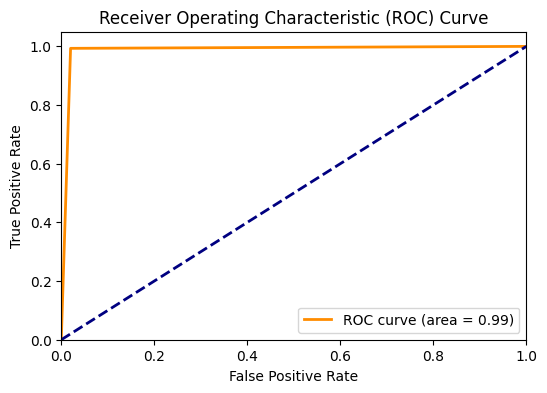

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import cv2
import numpy as np
import os

def watershed(img):
    source = img.copy()
    shifted = cv2.pyrMeanShiftFiltering(img, 30, 30)

    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)

    markers = markers + 1

    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 255, 0]
    img[markers == 1] = [0, 0, 0]
    dst = cv2.addWeighted(source, 0.5, img, 1.5, 0)

    return dst

def process_dataset(dataset_path):
    subsets = ["Bengin cases", "Malignant cases", "Normal cases"]
    for subset in subsets:
        subset_path = os.path.join(dataset_path, subset)
        output_path = os.path.join(dataset_path, subset + "_segmented")
        os.makedirs(output_path, exist_ok=True)

        for filename in os.listdir(subset_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(subset_path, filename)
                img = cv2.imread(img_path)
                segmented_img = watershed(img)
                output_img_path = os.path.join(output_path, filename)
                cv2.imwrite(output_img_path, segmented_img)
                print(f"Segmented image saved: {output_img_path}")

dataset_path = r"/content/drive/MyDrive/lung_cancer/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
process_dataset(dataset_path)


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
data_directory = './'
epochs = 10
batch_size = 32
learning_rate = 0.0001
stepLR = 5
momentum = 0.9
print(f"data_directory: {data_directory}, epochs: {epochs}, batch_size: {batch_size}, learning_rate: {learning_rate}, stepLR: {stepLR}, momentum: {momentum}")
DIR_PATH = r"/content/drive/MyDrive/data_set3"
if DIR_PATH[-1]=='/':
    DIR_PATH = DIR_PATH[:-1]
TRAIN_DIR_PATH = os.path.join(DIR_PATH, 'train')
VAL_DIR_PATH = os.path.join(DIR_PATH, 'val')
print(TRAIN_DIR_PATH )
print(VAL_DIR_PATH )
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(mean)
print(std)
transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1),shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

}
train_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/data_set3/train", transform=transformations['train'])
val_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/data_set3/test", transform=transformations['val'])
test_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/val", transform=transformations['test'])


classes_to_idx = train_dataset.class_to_idx
print(classes_to_idx)
train_batch_size = batch_size
learning_rate = learning_rate
num_classes = len(classes_to_idx)
num_epochs = epochs
print(train_batch_size)
print(learning_rate)
print(num_classes )
print(num_epochs)
phases = ['training', 'validation']

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4),
    'testing':DataLoader(dataset=test_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4)
}
for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')

model = torchvision.models.resnet101(pretrained=True)
model = model.to(device)
print(model)
model = ConvNet(model, num_classes)
model = model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=stepLR, gamma=0.1)
print(criterion)
print(optimizer)
print(exp_lr_scheduler)


data_directory: ./, epochs: 10, batch_size: 32, learning_rate: 0.0001, stepLR: 5, momentum: 0.9
/content/drive/MyDrive/data_set3/train
/content/drive/MyDrive/data_set3/val
[0.485 0.456 0.406]
[0.229 0.224 0.225]
{'LUNG_CANCER': 0, 'NORMAL': 1}
32
0.0001
2
10
Length of training loader = 43
Length of validation loader = 451


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can al

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
start = time.time()
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size, num_epochs)
duration = time.time() - start
print(f'Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [1/10] Phase: training | Loss: 9.928404 Accuracy: 0.848837
Epoch: [1/10] Phase: validation | Loss: 0.129062 Accuracy: 0.953437
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.953437
-------------------------------------------------------------------------
Epoch: [2/10] Phase: training | Loss: 4.513954 Accuracy: 0.934593
Epoch: [2/10] Phase: validation | Loss: 0.132760 Accuracy: 0.953437
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.953437
-------------------------------------------------------------------------
Epoch: [3/10] Phase: training | Loss: 3.798345 Accuracy: 0.941134
Epoch: [3/10] Phase: validation | Loss: 0.060686 Accuracy: 0.986696
====> Best accuracy reached so far at Epoch 3 Accuracy = 0.986696
-------------------------------------------------------------------------
Epoch: [4/10] Phase: training | Loss: 3.496854 Accuracy: 0.947674
Epoch: [4/10] Phase: validation | Loss: 0.057699 Accuracy: 0.984479
--------------------------------------------

In [ ]:
torch.save(model.state_dict(), 'lung_cancer101_.pth')

Validation Loss: 0.016509, Validation Accuracy: 0.995565
Accuracy: 0.995565
Precision: 0.996678
Recall: 0.996678
F1-Score: 0.996678
Confusion Matrix:
[[149   1]
 [  1 300]]


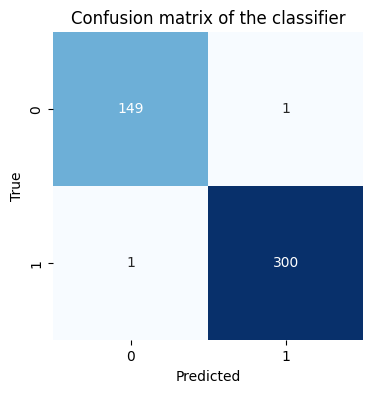

In [ ]:
import seaborn as sns
def evaluate_model(model, criterion, data_loader, phase):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader[phase]:
            images = images.to(device)
            labels = labels.to(device)

            _, outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader[phase].dataset)
    epoch_accuracy = running_corrects.double() / len(data_loader[phase].dataset)

    return epoch_loss, epoch_accuracy, all_labels, all_preds

val_loss, val_accuracy, all_labels, all_preds = evaluate_model(model, criterion, data_loader, 'validation')
print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-Score: {f1:.6f}')
print('Confusion Matrix:')
print(conf_matrix)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Extracting macro and weighted averages
from sklearn.metrics import classification_report

report_dict = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

macro_avg = report_dict['macro avg']
weighted_avg = report_dict['weighted avg']

print("Macro Average:")
print(f"Precision: {macro_avg['precision']:.6f}")
print(f"Recall: {macro_avg['recall']:.6f}")
print(f"F1-Score: {macro_avg['f1-score']:.6f}")
print(f"Support: {macro_avg['support']:.6f}")

print("\nWeighted Average:")
print(f"Precision: {weighted_avg['precision']:.6f}")
print(f"Recall: {weighted_avg['recall']:.6f}")
print(f"F1-Score: {weighted_avg['f1-score']:.6f}")
print(f"Support: {weighted_avg['support']:.6f}")


Macro Average:
Precision: 0.995006
Recall: 0.995006
F1-Score: 0.995006
Support: 451.000000

Weighted Average:
Precision: 0.995565
Recall: 0.995565
F1-Score: 0.995565
Support: 451.000000


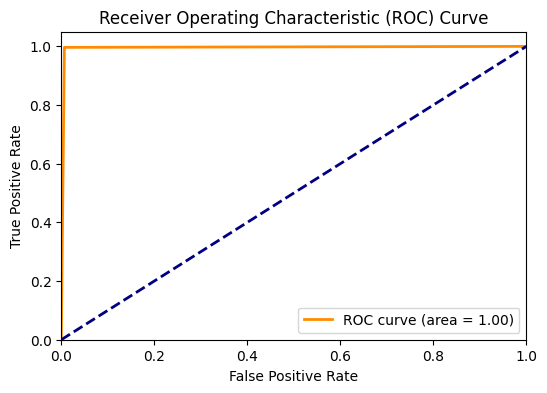

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
data_directory = './'
epochs = 10
batch_size = 32
learning_rate = 0.0001
stepLR = 5
momentum = 0.9
print(f"data_directory: {data_directory}, epochs: {epochs}, batch_size: {batch_size}, learning_rate: {learning_rate}, stepLR: {stepLR}, momentum: {momentum}")
DIR_PATH = r"/content/drive/MyDrive/data_set3"
if DIR_PATH[-1]=='/':
    DIR_PATH = DIR_PATH[:-1]
TRAIN_DIR_PATH = os.path.join(DIR_PATH, 'train')
VAL_DIR_PATH = os.path.join(DIR_PATH, 'val')
print(TRAIN_DIR_PATH )
print(VAL_DIR_PATH )
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(mean)
print(std)
transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1),shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

}
train_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/data_set3/train", transform=transformations['train'])
val_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/data_set3/test", transform=transformations['val'])
test_dataset = torchvision.datasets.ImageFolder(r"/content/drive/MyDrive/val", transform=transformations['test'])


classes_to_idx = train_dataset.class_to_idx
print(classes_to_idx)
train_batch_size = batch_size
learning_rate = learning_rate
num_classes = len(classes_to_idx)
num_epochs = epochs
print(train_batch_size)
print(learning_rate)
print(num_classes )
print(num_epochs)
phases = ['training', 'validation']

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4),
    'testing':DataLoader(dataset=test_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4)
}
for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')

model = torchvision.models.resnet152(pretrained=True)
model = model.to(device)
print(model)
model = ConvNet(model, num_classes)
model = model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=stepLR, gamma=0.1)
print(criterion)
print(optimizer)
print(exp_lr_scheduler)


data_directory: ./, epochs: 10, batch_size: 32, learning_rate: 0.0001, stepLR: 5, momentum: 0.9
/content/drive/MyDrive/data_set3/train
/content/drive/MyDrive/data_set3/val
[0.485 0.456 0.406]
[0.229 0.224 0.225]
{'LUNG_CANCER': 0, 'NORMAL': 1}
32
0.0001
2
10
Length of training loader = 43
Length of validation loader = 451


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can al

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
start = time.time()
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size, num_epochs)
duration = time.time() - start
print(f'Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [1/10] Phase: training | Loss: 10.134318 Accuracy: 0.836483
Epoch: [1/10] Phase: validation | Loss: 1.587329 Accuracy: 0.676275
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.676275
-------------------------------------------------------------------------
Epoch: [2/10] Phase: training | Loss: 4.198030 Accuracy: 0.933140
Epoch: [2/10] Phase: validation | Loss: 0.239274 Accuracy: 0.904656
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.904656
-------------------------------------------------------------------------
Epoch: [3/10] Phase: training | Loss: 3.089781 Accuracy: 0.954215
Epoch: [3/10] Phase: validation | Loss: 1.043184 Accuracy: 0.753880
-------------------------------------------------------------------------
Epoch: [4/10] Phase: training | Loss: 2.311520 Accuracy: 0.962936
Epoch: [4/10] Phase: validation | Loss: 2.219750 Accuracy: 0.682927
-------------------------------------------------------------------------
Epoch: [5/10] Phase: training | Los

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.031149, Validation Accuracy: 0.993348
Accuracy: 0.993348
Precision: 0.990132
Recall: 1.000000
F1-Score: 0.995041
Confusion Matrix:
[[147   3]
 [  0 301]]


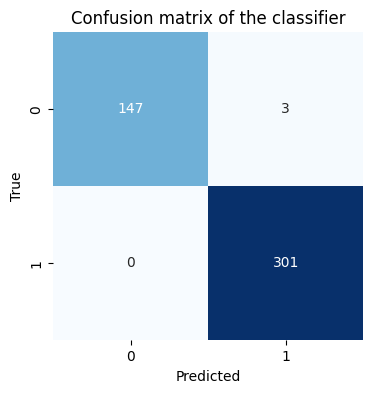

In [ ]:
import seaborn as sns
def evaluate_model(model, criterion, data_loader, phase):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader[phase]:
            images = images.to(device)
            labels = labels.to(device)

            _, outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader[phase].dataset)
    epoch_accuracy = running_corrects.double() / len(data_loader[phase].dataset)

    return epoch_loss, epoch_accuracy, all_labels, all_preds

val_loss, val_accuracy, all_labels, all_preds = evaluate_model(model, criterion, data_loader, 'validation')
print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-Score: {f1:.6f}')
print('Confusion Matrix:')
print(conf_matrix)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Extracting macro and weighted averages
from sklearn.metrics import classification_report

report_dict = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

macro_avg = report_dict['macro avg']
weighted_avg = report_dict['weighted avg']

print("Macro Average:")
print(f"Precision: {macro_avg['precision']:.6f}")
print(f"Recall: {macro_avg['recall']:.6f}")
print(f"F1-Score: {macro_avg['f1-score']:.6f}")
print(f"Support: {macro_avg['support']:.6f}")

print("\nWeighted Average:")
print(f"Precision: {weighted_avg['precision']:.6f}")
print(f"Recall: {weighted_avg['recall']:.6f}")
print(f"F1-Score: {weighted_avg['f1-score']:.6f}")
print(f"Support: {weighted_avg['support']:.6f}")


Macro Average:
Precision: 0.995066
Recall: 0.990000
F1-Score: 0.992470
Support: 451.000000

Weighted Average:
Precision: 0.993414
Recall: 0.993348
F1-Score: 0.993331
Support: 451.000000


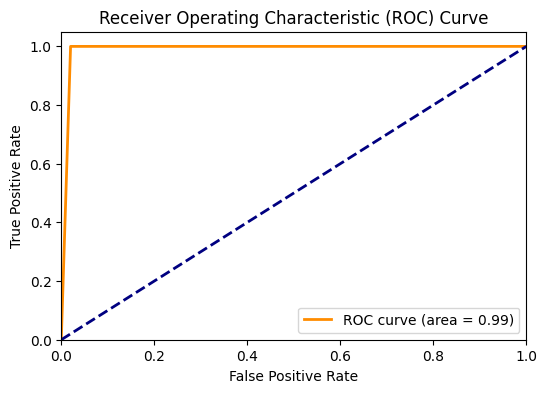

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
